In [1]:
import sys
sys.path.insert(0, "..")

import torch
import torch.nn as nn
from src.utils.provider import Provider, DictProvider
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchinfo import summary

In [8]:
t = np.asarray([2.0])
t

array([2.])

In [10]:
t[0] = 3.0
t

array([6.])

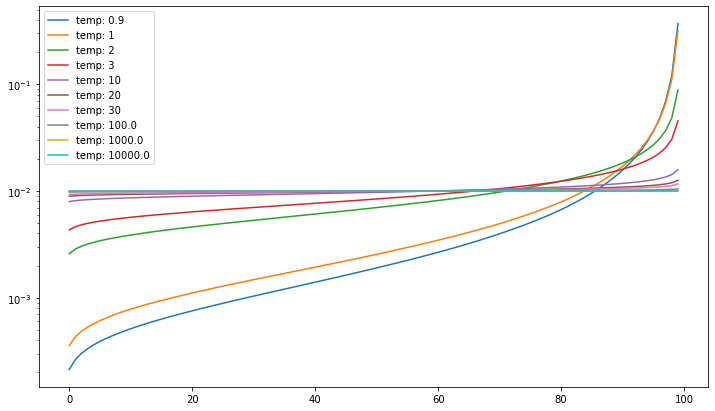

In [53]:
# show gumbel softmax plots

n = 100
q = 10000
temp = [0.9, 1, 2, 3, 10, 20, 30, 1e2, 1e3, 1e4]

plt.figure(figsize=(12, 7))

for t in temp:
    data = F.gumbel_softmax(torch.ones((q, n)), tau=np.array(t)).sort(dim=-1).values.mean(dim=0)
    plt.plot(np.arange(n), data)

plt.legend([f'temp: {t}' for t in temp])
plt.yscale('log')

# Anything above temp 20 is useless
# use cosine decay from temp 20 -> 0.1

In [2]:
ip = torch.zeros((1, 3, 32, 32)).to('cuda')
ip2 = torch.zeros((1, 1)).to('cuda')

In [3]:
from src.torchmodules.sr3_diffusion.unet_attention import UNetWithAttention

m = UNetWithAttention(out_channels=3)
m = m.to('cuda')

# m(ip, ip2)

summary(m, input_data=(ip, ip2))

/home/jaideep/miniconda3/envs/mtpignite/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                                                                                                                                                                                                                                                                                                                                                   Output Shape              Param #
UNetWithAttention                                                                                                                                                                                                                                                                                                                                                        --                        --
├─BufferDict: 1-1                                                                                                                                                                                                      

In [4]:
next(m.parameters()).device

device(type='cuda', index=0)

In [5]:
m.forward_measurements({'flops': torch.zeros((1)).to('cuda')})

  complete contraction:  abcde,abcfg->abdefg
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcdef,abgef->abgcd
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcde,abcfg->abdefg
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcdef,abgef->abgcd
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcde,abcfg->abdefg
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcdef,abgef->abgcd
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop coun

{'flops': tensor([2.8938e+17], device='cuda:0')}

In [6]:
from src.torchmodules.sr3_diffusion.unet_attention import UNetWithAttentionSupernet

def mask_to_first(ops):
    for name, op in ops.items():
        op.operation_mask.fill_(False)
        op.operation_mask[0] = True

m = UNetWithAttentionSupernet(
    out_channels=3,
    subnet_mask_fn=mask_to_first,
)
m = m.to("cuda")

m(ip, ip2)

summary(m, input_data=(ip, ip2))


Layer (type:depth-idx)                                                                                                                                                                                                                                                                                                                                                        Output Shape              Param #
UNetWithAttentionSupernet                                                                                                                                                                                                                                                                                                                                                     --                        --
├─ModuleDict: 1                                                                                                                                                                                              

In [9]:
sub = m.current_subnet()

In [11]:
summary(sub, input_data=(ip, ip2))

Layer (type:depth-idx)                                                                                                                                                                                                                                                                                                                                              Output Shape              Param #
UNetWithAttentionSupernet                                                                                                                                                                                                                                                                                                                                           --                        --
├─Module: 1                                                                                                                                                                                                                      

In [ ]:
# _=sub.load_state_dict(m.state_dict(), strict=False)

In [12]:
with m.subnet_masked():
    op1 = m(ip, ip2)
    op1_1 = m(ip, ip2)
    op2 = sub(ip, ip2)

print(f'  op1 == op2 ', (op1 == op2).all())
print(f'| op1 - op2 |', (op1-op2).abs().max())
print(f'| op1 - op2 |', (op1-op2).abs().mean())

print()

print(f'  op1 == op1_1 ', (op1 == op1_1).all())
print(f'| op1 - op1_1 |', (op1-op1_1).abs().max())
print(f'| op1 - op1_1 |', (op1-op1_1).abs().mean())

  op1 == op2  tensor(True, device='cuda:0')
| op1 - op2 | tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
| op1 - op2 | tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)

  op1 == op1_1  tensor(True, device='cuda:0')
| op1 - op1_1 | tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
| op1 - op1_1 | tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
op1, op2, op1_1